# English Notebook

## Import basic libraries and dependencies

In [1]:
import sys
import importlib

sys.path.append('./modules')
from config import English, Bengali

## Set a language

In [2]:
LANG = English # English, Bengali

# 0. Language overview
Some characteristics of the English language are:

- Native speakers: around 360 million.
- Language family: 	Indo-European > Germanic > West Germanic > Ingvaeonic > Anglo-Frisian > Anglic > English.
- Vocabulary size: 170,000 words, or 220,000 if obsolete words are counted.
- Writing system: 
    + written in [Latin alphabet](https://en.wikipedia.org/wiki/Latin_alphabet).
    + 26 letters, plus their corresponding capital form.
    + 14 puntuaction marks.
- Phonology: 
    + 24 consonant phonemes.
    + pronunciation of vowels varies a great deal between dialects.


# 1. Data Preparation

**Assumptions**:
- Two-or-more end-of-line symbols (e.g. '\n\n') signify the separation of two paragraphs.
- No single sentence resides in more than one paragraph.
- We are allowed to use `nltk` for sentence-tokenization. The function from `nltk` (`nltk.tokenize.sent_tokenize`) is sufficient for the task.
- There is no situation where double-space makes sense, so we contract all sequences of more than one space into a space character (i.e. from the regex point of view, ' +' is substituted with ' ').

**Operations**:
- Get a list of paragraphs by splitting the text by at-least-2 consecutive end-of-line characters (i.e. '\n{2,}').
- For each paragraph:
    + Replace all end-of-line characters with a space.
    + Contract all sequences of more than one space into a space character.
    + Tokenize into sentences.
- Collect all sentences from all paragraphs as a list and return.


In [3]:
# import libraries and dependencies
import preprocessing
import utils
importlib.reload(preprocessing)
from preprocessing import raw_preprocess, split_train_test

## 1.1. Preprocess data for sentencepiece

In [4]:
# preprocess raw data to get a list of sentences.
sentences = raw_preprocess(LANG)

# write the sentences into a file, each sentence on one line.
with open(f'data/{LANG.name}/preprocessed.txt', 'w') as f:
    for sentence in sentences:
        f.write(f'{sentence}\n')

utils.print_length_statistics(sentences)

Num. of sentences = 1707
Avg. length = 82.49560632688927
Std. dev. of the length = 82.6500329930229
Maximum length = 919
Minimum length = 3


## 1.2. Train/test split

In [5]:
# split data to train and test.
train, test = split_train_test(sentences, LANG)

# write train and test data into corresponding files.
train_path = f'data/{LANG.name}/train.txt'
test_path = f'data/{LANG.name}/test.txt'

with open(train_path, 'w') as f:
    f.write('\n'.join(train))
with open(test_path, 'w') as f:
    f.write('\n'.join(test))

# 2. Subword segmentation

In this section, we work on 3 segmentation models with difference vocabulary sizes. The first one employs character-level segmentation, which is simply to treat each character as a token, resulting in a vocabulary size of 74. In the rest of this section, we focus mostly on the other 2 models.

## 2.1. Experiments with vocabulary sizes

There are 2 types of subword: small vocabulary size (i.e. usually from 100 to 800) and large vocabulary size (i.e. from 1500 to 3000). For each type, we do some experiments to choose an exact vocabulary size, which will be fixed for subsequent tasks.

**Approach**:

We propose to employ the [Minimum Description Length (MDL)](https://en.wikipedia.org/wiki/Minimum_description_length) principle to tackle this task. The MDL is a technique for model selection inspired by Occam's razor. In its basic form, MDL prefers the model which summarizes the data the best, i.e. the total size of the model and the description of the data given the model is the smallest.

![figures/MLD_1.PNG](figures/MLD_1.PNG)

For our current task, we formalize the description length as the total size of the model file, the vocab file and the encoded text file. In which, the model file and the vocab file represent the model, and the encoded file represents the data given the model.

![figures/MLD_2.PNG](figures/MLD_2.PNG)

To prevent from overfitting, we only consider vocab sizes rounded to hundredth, i.e. 100, 200, ..., 800 and 1500, 1600, ..., 3000. The best vocabulary size is chosen as the one which results in the smallest description length per the formulation above.


**Experiment details**:

a. Small vocabulary:

For small vocabulary sizes (from 100 to 800), the corresponding description length (or total file size) is shown in the figure below. The smallest description length belongs to the vocabulary size of 500.

![figures/en/task2.3_small_vocab_file_size.png](figures/en/task2.3_small_vocab_file_size.png)

One interesting observation is that the description length decreases sharply from vocabulary size of 100 to 200. For a qualitative evalution, let us look at an examplar sentence:

original text:

> There was a table set out under a tree in front of the house, and the March Hare and the Hatter were having tea at it: a Dormouse was sitting between them, fast asleep, and the other two were using it as a cushion, resting their elbows on it, and talking over its head.

vocab_size = 100:

> ▁ T he re ▁w a s ▁a ▁t a b l e ▁s e t ▁ ou t ▁ u nd er ▁a ▁t re e ▁ in ▁ f r o n t ▁o f ▁the ▁ h ou s e , ▁and ▁the ▁ M a r c h ▁ H a re ▁and ▁the ▁ H a t t er ▁w er e ▁ ha v ing ▁t e a ▁a t ▁ it : ▁a ▁ D o r m ou s e ▁w a s ▁s it t ing ▁b e t w e en ▁the m , ▁ f a s t ▁a s l e e p , ▁and ▁the ▁o t he r ▁t w o ▁w er e ▁ u s ing ▁ it ▁a s ▁a ▁c u s h i o n , ▁ re s t ing ▁the i r ▁ e l b o w s ▁o n ▁ it , ▁and ▁t a l k ing ▁o v er ▁ it s ▁ he a d .

vocab_size = 200:

> ▁T he re ▁was ▁a ▁t a b le ▁s et ▁ out ▁u nd er ▁a ▁t re e ▁in ▁f r on t ▁of ▁the ▁h ou se , ▁and ▁the ▁M ar ch ▁H a re ▁and ▁the ▁H at ter ▁w er e ▁ha v ing ▁t ea ▁at ▁it : ▁a ▁D or m ou se ▁was ▁s it t ing ▁be t w e en ▁the m , ▁f as t ▁as le e p , ▁and ▁the ▁o t her ▁t w o ▁w er e ▁u s ing ▁it ▁as ▁a ▁c u s h i on , ▁re st ing ▁the ir ▁e l b ow s ▁on ▁it , ▁and ▁t a l k ing ▁o ver ▁it s ▁he ad .

vocab_size = 500:

> ▁The re ▁was ▁a ▁t able ▁s et ▁out ▁u nder ▁a ▁t ree ▁in ▁fr on t ▁of ▁the ▁h ouse , ▁and ▁the ▁March ▁H are ▁and ▁the ▁Hatter ▁were ▁ha v ing ▁t ea ▁at ▁it : ▁a ▁Dormouse ▁was ▁s it ting ▁be t w een ▁them , ▁f ast ▁as le e p , ▁and ▁the ▁other ▁tw o ▁were ▁us ing ▁it ▁as ▁a ▁c us h ion , ▁re st ing ▁their ▁e l b ow s ▁on ▁it , ▁and ▁t al king ▁over ▁its ▁head .

For the size of 100, nearly every token is a character, which is obviously a bad sign since it cannot utilize the use of longer subwords or words to foster learning. Note that since this text has roughtly 72 characters, only 100-72=28 combinations of characters are taken as tokens for this size. 

For the size of 200, more meaningful combinations of characters are recognized as a token. In particular, the number almost quintuples from 28 to 128. As an example, *'ing'* has its own place. This explains the great drop in the description length.

This trend continues up to the size of 500, where the trade-off between generality and specificity of adding new tokens equalizes. Most of the stopwords, which are very frequent, occupy their own tokens. Meaningful suffixes like *'able'* now also have their own place. 

While a vocabulary size of 500 is quite small in practice, we believe it is suitable for our current problem since the input text file is small.

b. Large vocabulary

For large vocabulary sizes (from 1500 to 3000), we apply the same procedure as described. The description lengths corresponding to different sizes are shown below: 

![figures/en/task2.3_large_vocab_file_size.png](figures/en/task2.3_large_vocab_file_size.png)

It can be observed from the figure that the larger the vocabulary size, the longer the description length. We suspect that this is because 1500 is already bigger than the optimal size, thus adding more tokens only makes things worse. For the purposes of the next tasks, we will use the size of 1500 for the large vocabulary size.

Regarding the example above, let us look at how the sentence is segmented:

vocab_size = 1500:

> ▁There ▁was ▁a ▁table ▁set ▁out ▁under ▁a ▁t ree ▁in ▁fr on t ▁of ▁the ▁house , ▁and ▁the ▁March ▁Hare ▁and ▁the ▁Hatter ▁were ▁having ▁tea ▁at ▁it : ▁a ▁Dormouse ▁was ▁sitting ▁bet w een ▁them , ▁f ast ▁asleep , ▁and ▁the ▁other ▁two ▁were ▁us ing ▁it ▁as ▁a ▁c ush ion , ▁rest ing ▁their ▁el b ow s ▁on ▁it , ▁and ▁talking ▁over ▁its ▁head .

We can see that most of the words are standing alone as a token. This becomes close to word-level segmentation, which may potentially reduce the advantages of using sub-words for handling OOV.

## 2.2. Training of Segmentation models

**Operations**:
- We train 3 segmentation models of different vocabulary sizes:
    - character-level segmentation.
    - small subword vocabulary size of 500.
    - large subword vocabulary size of 1500.
- For each vocabulary size, we:
    - train a segmentation model.
    - apply the model on the training data to get an encoded text.
    - decode the encoded text, verify that the decoded text is the same as the original training data to ensure the correctness of the model.
    - apply the same encoding, decoding operations on the test data.   

In [6]:
# import libraries and dependencies
import segmentation
importlib.reload(segmentation)
from segmentation import train_segmentation, encode_text_file, decode_text_file
from config import seg_profiles

In [7]:
seg_profiles[LANG.name]

[SegmentationConf(id='s1', vocab_size=None, model_type='char'),
 SegmentationConf(id='s2', vocab_size=500, model_type='bpe'),
 SegmentationConf(id='s3', vocab_size=1500, model_type='bpe')]

In [ ]:
for seg in seg_profiles[LANG.name]:
    # train segmentation on the train data
    spm1 = train_segmentation(
        text_file=train_path, 
        LANG=LANG, 
        vocab_size=seg.vocab_size, 
        model_type=seg.model_type)
  
    encoded_file = f'data/{LANG.name}/segmentation/{seg.id}.txt'
    encode_text_file(text_file=train_path, model_path=spm1, output_file=encoded_file)
    
    decoded_file = f'data/{LANG.name}/segmentation/{seg.id}_decoded.txt'
    decode_text_file(text_file=encoded_file, model_path=spm1, output_file=decoded_file)
    
    # test it on the test data
    encoded_file = f'data/{LANG.name}/segmentation/{seg.id}_test.txt'
    encode_text_file(text_file=test_path, model_path=spm1, output_file=encoded_file)
    
    decoded_file = f'data/{LANG.name}/segmentation/{seg.id}_decoded_test.txt'
    decode_text_file(text_file=encoded_file, model_path=spm1, output_file=decoded_file)

# 3. Language Model

## 3.1. Baseline

In [8]:
from config import baseline_conf
baseline_conf

TrainingConf(hidden=40, rand_seed=1, debug=2, bptt=4, n_class=9999)

Executing the following cell will delete the already trained language models. To simply see the perplexity of the trained models, skip this cell and execute the next one.

In [ ]:
for seg in seg_profiles[LANG.name]:
    # Hyper parameters
    hidden = baseline_conf.hidden
    rand_seed = baseline_conf.rand_seed
    debug = baseline_conf.debug
    bptt = baseline_conf.bptt
    n_class = baseline_conf.n_class

    # Parameters
    model_path = f'models/rnnlm/{LANG.name}/{seg.id}_baseline'
    train_path = f'../../../../data/{LANG.name}/segmentation/{seg.id}.txt'
    valid_path = f'../../../../data/{LANG.name}/segmentation/{seg.id}_test.txt'

    # run the model 
    !rm -rf $model_path \
      && mkdir $model_path \
      && cd $model_path \
      && ../../../../rnnlm-0.3e/rnnlm \
        -train $train_path \
        -valid $valid_path \
        -rnnlm model \
        -hidden $hidden \
        -rand-seed $rand_seed \
        -debug $debug \
        -bptt $bptt \
        -class $n_class

The validation perplexities of the baseline models are:

In [9]:
for seg in seg_profiles[LANG.name]:
    model_path = f'models/rnnlm/{LANG.name}/{seg.id}_baseline'
        
    # read output and print perplexity
    with open(f'{model_path}/model.output.txt', 'r') as f:
        output = f.read()
        pp = output.split()[-1]
        print(f'Baseline {LANG.name}-{seg.id} validation perplexity: {pp}')

Baseline en-s1 validation perplexity: 5.257669
Baseline en-s2 validation perplexity: 33.814382
Baseline en-s3 validation perplexity: 85.886606



## 3.2. Experiments

**Approach**:

To cover a wide range of hyperparameter values, we employ grid search.

**Operations**:

For each model, we do grid search on 3 hyperparameters: 
- `hidden`: the number of neurons in the hidden layer,
- `bptt`: the number of steps in time that error is backpropagated,
- `class`: the number of classes for class-based LM.

The exact list of values for each hyperparameters can be seen in the code. Note that for the `hidden`, we set an upperbound of 200 as suggested by the authors of the [rnnlm toolkit](http://www.fit.vutbr.cz/~imikolov/rnnlm/FAQ.txt) for small texts with less than 1M words. For the `class`, all values greater than or equal to 1500 are equivalent (since the maximum vocabulary size we selected in the previous section is 1500). Here we set an upperbound of 1501.

In [10]:
import pickle
import itertools

In [11]:
# experimented results are kept in a file
grid_result_file = f'experiments/{LANG.name}/task3_grid_search.pickle'
# grid_results stores the results in memory
grid_results = {}

# import previous results if exists

with open(grid_result_file, 'rb') as f:
    previous_results = pickle.load(f)
    grid_results.update(previous_results)

grid_results

{('en', 's1', 5, 0, 10): 10.887227,
 ('en', 's1', 5, 0, 100): 10.645946,
 ('en', 's1', 5, 0, 1501): 10.482386,
 ('en', 's1', 5, 1, 10): 10.605196,
 ('en', 's1', 5, 1, 100): 10.271953,
 ('en', 's1', 5, 1, 1501): 10.261143,
 ('en', 's1', 5, 3, 10): 10.650879,
 ('en', 's1', 5, 3, 100): 10.273488,
 ('en', 's1', 5, 3, 1501): 10.1756,
 ('en', 's1', 5, 5, 10): 10.650509,
 ('en', 's1', 5, 5, 100): 10.275037,
 ('en', 's1', 5, 5, 1501): 10.170872,
 ('en', 's1', 20, 0, 10): 7.372125,
 ('en', 's1', 20, 0, 100): 6.910608,
 ('en', 's1', 20, 0, 1501): 7.039472,
 ('en', 's1', 20, 1, 10): 6.759173,
 ('en', 's1', 20, 1, 100): 6.477795,
 ('en', 's1', 20, 1, 1501): 6.552387,
 ('en', 's1', 20, 3, 10): 6.617757,
 ('en', 's1', 20, 3, 100): 6.550642,
 ('en', 's1', 20, 3, 1501): 6.441925,
 ('en', 's1', 20, 5, 10): 6.675042,
 ('en', 's1', 20, 5, 100): 6.571401,
 ('en', 's1', 20, 5, 1501): 6.611228,
 ('en', 's1', 40, 0, 10): 6.051518,
 ('en', 's1', 40, 0, 100): 5.971961,
 ('en', 's1', 40, 0, 1501): 5.99838,
 ('e

In [ ]:
hidden_choices = [5, 20, 40, 70, 100, 150, 200]
bptt_choices = [0, 1, 3, 5]
class_choices = [10, 100, 1501]
rand_seed = 1
debug = 2

for seg, hidden, bptt, _class in itertools.product(
    seg_profiles[LANG.name], hidden_choices, bptt_choices, class_choices):

    if (LANG.name, seg.id, hidden, bptt, _class) in grid_results:
        print(f'skip {LANG.name} {seg.id} {hidden} {bptt} {_class}')
        continue

    # Parameters
    model_path = f'models/rnnlm/{LANG.name}/{seg.id}'
    train_path = f'../../../../data/{LANG.name}/segmentation/{seg.id}.txt'
    valid_path = f'../../../../data/{LANG.name}/segmentation/{seg.id}_test.txt'

    # run the model 
    !rm -rf $model_path \
      && mkdir $model_path \
      && cd $model_path \
      && ../../../../rnnlm-0.3e/rnnlm \
        -train $train_path \
        -valid $valid_path \
        -rnnlm model \
        -hidden $hidden \
        -rand-seed $rand_seed \
        -debug $debug \
        -bptt $bptt \
        -class $_class \
        2> error.txt

    # read output extract validation perplexity
    with open(f'{model_path}/model.output.txt', 'r') as f:
        output = f.read()
        pp = float(output.split()[-1])
        grid_results[(LANG.name, seg.id, hidden, bptt, _class)] = pp

    # write current results to file
    with open(grid_result_file, 'wb') as f:
        pickle.dump(grid_results, f)


**Observations**:

The following plots show how the perplexity of the model varies when changing each of the hyperparameters, while leaving the rest fixed. 

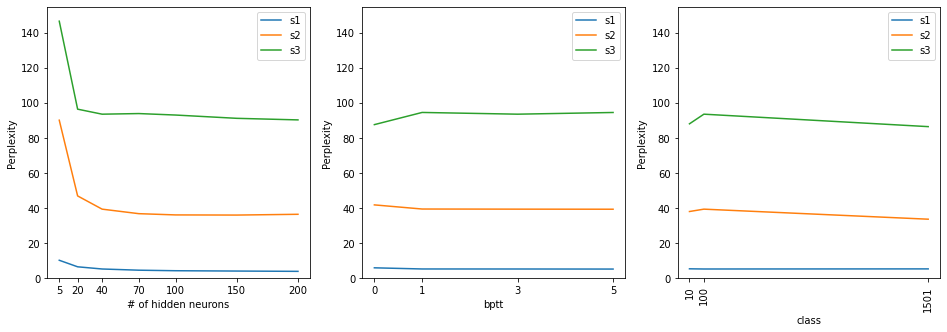

In [12]:
import visualisation 

visualisation.plot_grid_results(English, grid_results)

The first plot shows the perplexity values for different sizes of the `hidden` layer of the RNNLM for a fixed value of `bptt` and `class`. In all cases, increasing the number of hidden layers gives a lower (better) perplexity. For `s1` and `s2`, changing from 5 to 20 hidden neurons implies a huge decrease. The intensity of change is lessened when there are more and more neurons. From 100 neurons onwards, the differences are negligible.

The second plot shows how the perplexity varies with `bptt`. In general, this hyperparameter does not have a major impact to the perplexity. While for `s1` and `s2`, increasing `bptt` from 0 to 1 results in slightly better perplexities, the reverse is true for `s3`. Higher values of `bptt` then have almost no impact to the perplexity on average.

The variation of the perplexity for different values of `class` is shown in the third plot. From 100, increasing the number of classes usually reduces the perplexity for the three vocabulary sizes. There is a trade-off between model performance and training speed: a higher value of `class` requires longer time to train but may result in a marginally better performance and vice versa.

Another interesting observation is that the overall performance of `s1` is much better than `s2`, which in turn is much better than `s3`. **We suspect this is because the *rnnlm toolkit* misunderstood the spaces in the input files (which represent separation between tokens) as meaningful characters of the text**. Thus, for `s1`, it can just predict that for any non-space character, the next character is a space, and then it has half of the predictions correct, which results in such a low perplexity. Since we are more focused on OOV handling but not perplexity optimization, we ignore this problem for the rest of the project.



**Results**:

There are different approaches to select the sets of optimal hyperparameters base on the above results and observations. One may follow Occam's Razor and prefer small values for the hyperparameters as long as the perplexity is only slightly higher than the minimum one. Another may directly choose the sets of values that result in the optimal perplexities. For simplicity, we opt for the second approach.

The configurations of hyperparameters that minimize the perplexity of the model for each vocabulary size are: 

In [13]:
for seg in seg_profiles[LANG.name]:
    results = dict((k, v) for (k, v) in grid_results.items() if k[1] == seg.id)
    print(f"{seg.id}: {min(results, key=results.get)}")

s1: ('en', 's1', 200, 3, 100)
s2: ('en', 's2', 200, 3, 1501)
s3: ('en', 's3', 40, 0, 1501)


or to be more explicit:

| vocab | hidden | bptt | class | (perplexity) |
|-------|--------|------|-------|--------------|
| s1    | 200    | 3    | 100   | 3.96         |
| s2    | 200    | 3    | 1501  | 31.36        |
| s3    | 40     | 0    | 1501  | 81.27        |

In [ ]:
# train and save LMs for the optimal configurations
importlib.reload(config)
from config import optimal_conf

for id, (hidden, rand_seed, debug, bptt, n_class) in \
    enumerate(optimal_conf[LANG.name], start=1):
    
    seg_id = f's{id}'

    # paths
    model_path = f'models/rnnlm/{LANG.name}/{seg_id}_optimal'
    train_path = f'../../../../data/{LANG.name}/segmentation/{seg_id}.txt'
    valid_path = f'../../../../data/{LANG.name}/segmentation/{seg_id}_test.txt'

    # run the model 
    !rm -rf $model_path \
      && mkdir $model_path \
      && cd $model_path \
      && ../../../../rnnlm-0.3e/rnnlm \
        -train $train_path \
        -valid $valid_path \
        -rnnlm model \
        -hidden $hidden \
        -rand-seed $rand_seed \
        -debug $debug \
        -bptt $bptt \
        -class $n_class

# 4. Text Generation

We generate texts of different lengths for each of the 6 language models (3 baseline and 3 optimal models) from section 3. The generated texts are then decoded by the corresponding segmentation models. Next, we compare the artificial texts of length 100.

In [5]:
from config import SEG_MODELS_PATH

## 4.1. Baseline models

In [6]:
for seg in seg_profiles[LANG.name]:
    gen_folder = f'data/{LANG.name}/generation/{seg.id}_baseline'
    # path to LM file
    language_model_file = f'models/rnnlm/{LANG.name}/{seg.id}_baseline/model'
    # path to segmentation file
    if seg.model_type == 'char':
        seg_model_file = f'{SEG_MODELS_PATH}/{LANG.name}/spm_{seg.model_type}.model'
    else:
        seg_model_file = f'{SEG_MODELS_PATH}/{LANG.name}/spm_{seg.model_type}_vocabsize-{seg.vocab_size}.model'
    
    # remove the text-generation folder
    !rm -rf $gen_folder \
        && mkdir $gen_folder
    
    for n_gen in [10, 100, 1000, 10000, 100000, 1000000, 10000000]:
        # generate text using rnnlm
        gen_file = f'{gen_folder}/{n_gen}.txt'
        !rnnlm-0.3e/rnnlm \
                -rnnlm $language_model_file \
                -gen $n_gen \
                -debug 0 \
            > $gen_file
        
        # decode generated text using sentencepiece
        decoded_gen_file = f'{gen_folder}/{n_gen}_decoded.txt'
        decode_text_file(gen_file, seg_model_file, decoded_gen_file)

`s1 baseline`:
> Withle his hear very time a lid shoup of bith could arraution pogg a won't ince: boghmendhed insee 

`s2 baseline`:
> Alice began little lesson--thege in courthed pice, as prie was the Criter kipp now in Wet, twink on, cards have cometely to that is any haird.  
`What hildider that flay too much nerept the way of you werehadge, will I can't anything out in your inter, if they'

`s3 baseline`:
> he took the Duchess--' to!'  
\`No are that,' said Alice, and all a nl t argo, beginning!'  
\`It's it how?'  
Arills all, I have go out of any a thing it written.'  
O E did you tast either you,' said the Mock Turtle; \` swro idea anyab came to know when the Nes!  
\`It's begunered to see them about, when I can tell you more

## 4.2. Tuned models

In [41]:
for seg in seg_profiles[LANG.name]:
    gen_folder = f'data/{LANG.name}/generation/{seg.id}'
    # path to LM file
    language_model_file = f'models/rnnlm/{LANG.name}/{seg.id}_optimal/model'
    # path to segmentation file
    if seg.model_type == 'char':
        seg_model_file = f'{SEG_MODELS_PATH}/{LANG.name}/spm_{seg.model_type}.model'
    else:
        seg_model_file = f'{SEG_MODELS_PATH}/{LANG.name}/spm_{seg.model_type}_vocabsize-{seg.vocab_size}.model'
    
    # remove the text-generation folder
    !rm -rf $gen_folder \
        && mkdir $gen_folder
    
    for n_gen in [10, 100, 1000, 10000, 100000, 1000000, 10000000]:
        # generate text using rnnlm
        gen_file = f'{gen_folder}/{n_gen}.txt'
        !rnnlm-0.3e/rnnlm \
                -rnnlm $language_model_file \
                -gen $n_gen \
                -debug 0 \
            > $gen_file
        
        # decode generated text using sentencepiece
        decoded_gen_file = f'{gen_folder}/{n_gen}_decoded.txt'
        decode_text_file(gen_file, seg_model_file, decoded_gen_file)

`s1 optimal`:
> \`If her head of a.'  
\`I should this losk, deen tone; \`But that's at remarked,' Alice found Alice, a

`s2 optimal`:
> Atter used the time in looked blows at the guess of the book, and he found on the pimmiast, the children last nearly.  
And she was goved, little she thought peep at it, so went to sure.  
poolowing the biture: but Alice toom at the musost, and a great song that s

`s3 optimal`:
> She said the Lpoty is, \` soon knew her teanher of a Fock tearenion, beautifulidly, and began finished her feet, that had an moral to get off; and behind it, and a great hard sadceen in that, howb jo under a poor little anything viola quietly.  
\`There's getting likeer about at them soto.  
said the Gryphon remarked, \`and this ear turned a tone of them sisterass

It can be seen that for both baseline and optimal models, the 3 texts have differences in length (in terms of number of characters). Since `s1` use only single characters as tokens, the text it generates is the shortest. On the other hand, `s3` generates the longest text because it uses more lengthier combinations of characters.

Overall, the optimal models show a better performance over the baseline models. This agrees with the reduction in perplexity that the optimal models were optimized for.

Regarding the optimal models, it looks like `s2` gives the highest quality of text. 
* For `s1`, the context seems very "short", each sentence comprises a small number of words, and words at moderate distance seems to be unrelated to each other. We deem this problem to be a consequence of using very short tokens (i.e. character tokens). For example, let's say the RNN LM can regard the last 10 tokens to generate the next token, if all those last 10 tokens are characters, then that effectively means our LM only has a context of 2 or 3 words. In contrast, if those tokens are all words themselves, then our LM has a larger context of 10 words.
    
* The same reasoning applies to explain why the text from `s3` gives longer sentence on average compared to the other models. Another observation taken from `s3` is that the generated text has many "meaningless" words like `teanher`, `tearenion`, `beautifulidly`. Note that these words didn't appear in the training data but rather are made up by the language model (by combining sub-words). The reason, as we suspect, is that since `s3` uses a large vocabulary size on a small training dataset, the statistics on its tokens are not significant (i.e. have low support), resulting in a bad performance.

* The text generated by `s2`, while still has many flaws, seems to be most realistic. Among the 3 models, `s2` does the best job on balancing between generality and specificity of the tokens, as well as maintaining a reasonable support for them.

# 5. OOV comparison

In this section, we compare the OOV rate of the original vocabulary and the augmented vocabularies from generated texts. (Note that we pre-process the texts with lower-casing and punctuation removal before computing OOV rates.)

In [17]:
import vocab_processing 
vocab_processing = importlib.reload(vocab_processing)
from vocab_processing import get_word_level_vocabulary, get_word_level_tokens, get_oov_rate

In [18]:
train_path = f'data/{LANG.name}/train.txt'
test_path = f'data/{LANG.name}/test.txt'

In [19]:
# get the training vocabulary on word-level
train_vocab = get_word_level_vocabulary(LANG, train_path)
# get the test tokens on word-level
test_tokens = get_word_level_tokens(LANG, test_path)
# compute and print OOV rate
oov_rate = get_oov_rate(train_vocab, test_tokens)
print(f'Original data\'s OOV rate: {oov_rate:.2%}')

Original data's OOV rate: 4.80%


## Augment vocabulary with generated data

### Baseline models

In [22]:
oov_rates = []

for seg in seg_profiles[LANG.name]:
    gen_folder = f'data/{LANG.name}/generation/{seg.id}_baseline'
    oov_rates.append([])
    
    for n_gen in [10, 100, 1000, 10000, 100000, 1000000, 10000000]:

        # obtain the vocabulary from the generated corpora
        decoded_gen_file = f'{gen_folder}/{n_gen}_decoded.txt'
        gen_vocab = get_word_level_vocabulary(LANG, decoded_gen_file)

        # compute the oov-rate on the augmented vocabulary
        augmented_oov_rate = get_oov_rate(train_vocab | gen_vocab, test_tokens)
        print(f'(Baseline) {LANG.name} {seg.id} {n_gen} OOV rate: {augmented_oov_rate:.2%}')
        oov_rates[-1].append(augmented_oov_rate)

(Baseline) en s1 10 OOV rate: 4.80%
(Baseline) en s1 100 OOV rate: 4.80%
(Baseline) en s1 1000 OOV rate: 4.80%
(Baseline) en s1 10000 OOV rate: 4.80%
(Baseline) en s1 100000 OOV rate: 4.62%
(Baseline) en s1 1000000 OOV rate: 4.21%
(Baseline) en s1 10000000 OOV rate: 3.41%
(Baseline) en s2 10 OOV rate: 4.80%
(Baseline) en s2 100 OOV rate: 4.80%
(Baseline) en s2 1000 OOV rate: 4.80%
(Baseline) en s2 10000 OOV rate: 4.75%
(Baseline) en s2 100000 OOV rate: 4.33%
(Baseline) en s2 1000000 OOV rate: 3.61%
(Baseline) en s2 10000000 OOV rate: 2.83%
(Baseline) en s3 10 OOV rate: 4.80%
(Baseline) en s3 100 OOV rate: 4.80%
(Baseline) en s3 1000 OOV rate: 4.79%
(Baseline) en s3 10000 OOV rate: 4.77%
(Baseline) en s3 100000 OOV rate: 4.51%
(Baseline) en s3 1000000 OOV rate: 3.94%
(Baseline) en s3 10000000 OOV rate: 3.20%


### Tuned models

In [23]:
for seg in seg_profiles[LANG.name]:
    gen_folder = f'data/{LANG.name}/generation/{seg.id}'
    oov_rates.append([])
    
    for n_gen in [10, 100, 1000, 10000, 100000, 1000000, 10000000]:

        # obtain the vocabulary from the generated corpora
        decoded_gen_file = f'{gen_folder}/{n_gen}_decoded.txt'
        gen_vocab = get_word_level_vocabulary(LANG, decoded_gen_file)

        # compute the oov-rate on the augmented vocabulary
        augmented_oov_rate = get_oov_rate(train_vocab | gen_vocab, test_tokens)
        print(f'(Tuned) {LANG.name} {seg.id} {n_gen} OOV rate: {augmented_oov_rate:.2%}')
        oov_rates[-1].append(augmented_oov_rate)

(Tuned) en s1 10 OOV rate: 4.80%
(Tuned) en s1 100 OOV rate: 4.80%
(Tuned) en s1 1000 OOV rate: 4.80%
(Tuned) en s1 10000 OOV rate: 4.79%
(Tuned) en s1 100000 OOV rate: 4.64%
(Tuned) en s1 1000000 OOV rate: 3.92%
(Tuned) en s1 10000000 OOV rate: 2.96%
(Tuned) en s2 10 OOV rate: 4.80%
(Tuned) en s2 100 OOV rate: 4.80%
(Tuned) en s2 1000 OOV rate: 4.80%
(Tuned) en s2 10000 OOV rate: 4.71%
(Tuned) en s2 100000 OOV rate: 4.33%
(Tuned) en s2 1000000 OOV rate: 3.59%
(Tuned) en s2 10000000 OOV rate: 2.71%
(Tuned) en s3 10 OOV rate: 4.80%
(Tuned) en s3 100 OOV rate: 4.80%
(Tuned) en s3 1000 OOV rate: 4.80%
(Tuned) en s3 10000 OOV rate: 4.73%
(Tuned) en s3 100000 OOV rate: 4.49%
(Tuned) en s3 1000000 OOV rate: 3.81%
(Tuned) en s3 10000000 OOV rate: 2.93%



While the original OOV rate is 4.80\%, augmenting the vocabulary with RNNLM's generated texts can effectively reduce this number, as shown in the below table and figure:

| model\gen size | $10^1$ | $10^2$ | $10^3$ | $10^4$ | $10^5$ | $10^6$ | $10^7$ |
|----------------|--------|--------|--------|--------|--------|--------|--------|
| s1_baseline    | 4.80%  | 4.80%  | 4.80%  | 4.80%  | 4.62%  | 4.21%  | 3.41%  |
| s2_baseline    | 4.80%  | 4.80%  | 4.80%  | 4.75%  | 4.33%  | 3.61%  | 2.83%  |
| s3_baseline    | 4.80%  | 4.80%  | 4.79%  | 4.77%  | 4.51%  | 3.94%  | 3.20%  |
|||||||||
| s1_optimal     | 4.80%  | 4.80%  | 4.80%  | 4.79%  | 4.64%  | 3.92%  | 2.96%  |
| s2_optimal     | 4.80%  | 4.80%  | 4.80%  | 4.71%  | 4.33%  | 3.59%  | 2.71%  |
| s3_optimal     | 4.80%  | 4.80%  | 4.80%  | 4.73%  | 4.49%  | 3.81%  | 2.93%  |

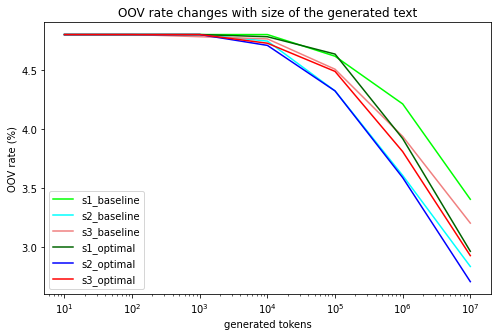

In [27]:
import visualisation
importlib.reload(visualisation)
from visualisation import plot_oov_rates
from config import FIGURES_PATH

#plot_oov_rates(oov_rates)
plot_oov_rates(oov_rates, save_path=f'{FIGURES_PATH}/{LANG.name}/task5_oov_rates.png')


**Observations**:
* There are almost no improvement in OOV rates if the augmenting text is small (i.e. less than or equal to $10^3$ tokens). OOV rates start decreasing from $10^4$ tokens, but the reduction is still quite small at that stage. OOV rates get lower with longer generated texts.
* From $10^5$ to $10^7$ tokens, the OOV rates of most models go almost linearly to the log of generated text size.
* Overall, given the same vocabulary size, the optimal models reduce the OOV rate better than the baseline models, especially when the number of generate tokens is significant (i.e. $10^6$ and $10^7$).
* In general, `s2` gives a better OOV rate than the other 2 models. This align well with our observation from above sections, where `s2` also showed superior results in terms of MDL and perplexity. 
* For practical applications, we would prefer `s2_optimal` over its counterparts.

# 6. Analysis

See section 6 of the Bengali notebook.